# Analyzing download speeds in Kentucky counties using Python

In this tutorial I will talk about how to:

    * Download the Ookla open dataset
    * Geocode the tiles to Kentucky counties
    * Make a table of the top and bottom 20 counties by download speed
    * Map the counties

There are two main ways to join these tiles to another geographic dataset: quadkeys and spatial joins. This tutorial will use the spatial join approach.

In [2]:
%matplotlib inline

from datetime import datetime

import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from shapely.geometry import Point
from adjustText import adjust_text

---

## Download data

First, download the data using the link below

In [3]:
def quarter_start(year: int, q: int) -> datetime:
    if not 1 <= q <= 4:
        raise ValueError("Quarter must be within [1, 2, 3, 4]")

    month = [1, 4, 7, 10]
    return datetime(year, month[q - 1], 1)


def get_tile_url(service_type: str, year: int, q: int) -> str:
    dt = quarter_start(year, q)

    base_url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance"
    url = f"{base_url}/type%3D{service_type}/year%3D{dt:%Y}/quarter%3D{q}/{dt:%Y-%m-%d}_performance_{service_type}_tiles.zip"
    return url

In [4]:
tile_url = get_tile_url("fixed", 2020, 2)
tile_url

'https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance/type%3Dfixed/year%3D2020/quarter%3D2/2020-04-01_performance_fixed_tiles.zip'

In [5]:
tiles = gp.read_file(tile_url)

In [6]:
tiles.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,1321222233020202,144116,125751,3,7330,1324,"POLYGON ((113.55469 22.16197, 113.56018 22.161..."
1,1230231303303002,89763,52939,42,726,137,"POLYGON ((55.41504 25.27947, 55.42053 25.27947..."
2,0313131210131030,62657,15479,19,271,40,"POLYGON ((-1.79077 51.55658, -1.78528 51.55658..."
3,0213330110110321,98061,11842,19,2,1,"POLYGON ((-93.22449 45.06576, -93.21899 45.065..."
4,3100130032202231,15167,7287,8,674,122,"POLYGON ((107.59460 -6.91552, 107.60010 -6.915..."


---

## Get county boundaries

Then, I’ll load the Kentucky county boundaries from the U.S. Census Bureau ftp site.

In [8]:
# zipfile of U.S. county boundaries
county_url = "https://www2.census.gov/geo/tiger/TIGER2023/COUNTY/tl_2023_us_county.zip" 
#state_url = "https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip	"
counties = gp.read_file(county_url)

In [9]:
# filter out the Kentucky fips code and reproject to match the tiles
ky_counties = counties.loc[counties['STATEFP'] == '06'].to_crs(4326)

In [10]:
ky_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
8,06,091,00277310,06091,0500000US06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2468694578,23299110,+39.5769252,-120.5219926,"POLYGON ((-120.55587 39.50874, -120.55614 39.5..."
324,06,067,00277298,06067,0500000US06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2500063005,75323439,+38.4501363,-121.3443291,"POLYGON ((-121.43991 38.25553, -121.44002 38.2..."
328,06,083,00277306,06083,0500000US06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7080874935,2729198796,+34.5366774,-120.0383645,"MULTIPOLYGON (((-120.58226 34.10752, -120.5790..."
345,06,009,01675885,06009,0500000US06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2641829627,43797225,+38.1910682,-120.5541065,"POLYGON ((-120.63179 38.34603, -120.63066 38.3..."
393,06,111,00277320,06111,0500000US06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4767585000,947376202,+34.3587477,-119.1331453,"MULTIPOLYGON (((-119.63607 33.28071, -119.6347..."


---

## Join tiles to counties

Now I’ll join the tiles to the counties. I use how = "inner" because I only want to include counties that have at least 1 tile.

In [11]:
tiles_in_ky_counties = gp.sjoin(tiles, ky_counties, how="inner", op='intersects')

/Users/beja/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [12]:
# convert to Mbps for easier reading
tiles_in_ky_counties['avg_d_mbps'] = tiles_in_ky_counties['avg_d_kbps'] / 1000
tiles_in_ky_counties['avg_u_mbps'] = tiles_in_ky_counties['avg_u_kbps'] / 1000

In [13]:
tiles_in_ky_counties.head()

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry,index_right,STATEFP,COUNTYFP,...,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,avg_d_mbps,avg_u_mbps
52,0230102033322301,113714,16899,16,253,53,"POLYGON ((-122.49207 37.73597, -122.48657 37.7...",635,06,075,...,488,41860,41884,C,120951669,479702222,+37.7272391,-123.0322294,113.714,16.899
152,0230102033333213,188310,181582,5,329,72,"POLYGON ((-122.37122 37.73162, -122.36572 37.7...",635,06,075,...,488,41860,41884,C,120951669,479702222,+37.7272391,-123.0322294,188.310,181.582
361,0230102033322131,130550,98798,10,329,56,"POLYGON ((-122.48108 37.74466, -122.47559 37.7...",635,06,075,...,488,41860,41884,C,120951669,479702222,+37.7272391,-123.0322294,130.550,98.798
1346,0230102033330220,158343,17198,43,404,106,"POLYGON ((-122.43164 37.76203, -122.42615 37.7...",635,06,075,...,488,41860,41884,C,120951669,479702222,+37.7272391,-123.0322294,158.343,17.198
1713,0230102033321313,167904,26932,19,615,137,"POLYGON ((-122.43713 37.76637, -122.43164 37.7...",635,06,075,...,488,41860,41884,C,120951669,479702222,+37.7272391,-123.0322294,167.904,26.932


---

## Make a table of the top 20 and bottom 20 counties

Next we can make a summary table of just the best and worst counties by download speed. We’ll require that counties have at least 50 tests so that the averages are more reliable.

In [14]:
# def weighted_mean(group, avg_name, weight_name):
#     """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
#     In rare instance, we may not have weights, so just return the mean. Customize this if your business case
#     should return otherwise.
#     """
#     d = group[avg_name]
#     w = group[weight_name]
#     try:
#         return (d * w).sum() / w.sum()
#     except ZeroDivisionError:
#         return d.mean()
    
county_stats = (
    tiles_in_ky_counties.groupby(["GEOID", "NAMELSAD"])
    .apply(
        lambda x: pd.Series(
            {"avg_d_mbps_wt": np.average(x["avg_d_mbps"], weights=x["tests"])}
        )
    )
    .reset_index()
    .merge(
        tiles_in_ky_counties.groupby(["GEOID", "NAMELSAD"])
        .agg(tests=("tests", "sum"))
        .reset_index(),
        on=["GEOID", "NAMELSAD"],
    )
)

In [28]:
print((county_stats))

# Filter county_stats for entries with "tests" >= 50
filtered_stats = county_stats.loc[county_stats["tests"] >= 50]

# Get the 20 largest and 20 smallest by "avg_d_mbps_wt"
largest_stats = filtered_stats.nlargest(20, "avg_d_mbps_wt")
smallest_stats = filtered_stats.nsmallest(20, "avg_d_mbps_wt")

# Concatenate the largest and smallest stats
table_stats = pd.concat([largest_stats, smallest_stats])

# Sort and round the result
table_stats = table_stats.sort_values("avg_d_mbps_wt", ascending=False).round(2)

# table_stats now contains the top 20 and bottom 20 entries, sorted by "avg_d_mbps_wt"


# table_stats = (
#     county_stats.loc[county_stats["tests"] >= 50]
#     .nlargest(20, "avg_d_mbps_wt")
#     .append(
#         county_stats.loc[county_stats["tests"] >= 50].nsmallest(20, "avg_d_mbps_wt")
#     )
#     .sort_values("avg_d_mbps_wt", ascending=False)
#     .round(2) # round to 2 decimal places for easier reading
# )

    GEOID                NAMELSAD  avg_d_mbps_wt    tests
0   06001          Alameda County     145.887730   246737
1   06003           Alpine County      18.684461      836
2   06005           Amador County      32.694890     2656
3   06007            Butte County     139.078939    11828
4   06009        Calaveras County      47.053515     5016
5   06011           Colusa County      37.508354      903
6   06013     Contra Costa County     156.493842   151217
7   06015        Del Norte County      82.939103     1702
8   06017        El Dorado County     110.219504    28548
9   06019           Fresno County     144.038766    74902
10  06021            Glenn County      97.694329      961
11  06023         Humboldt County     132.072823    11884
12  06025         Imperial County     111.609680    14724
13  06027             Inyo County      63.666006     1516
14  06029             Kern County     134.945996    88026
15  06031            Kings County     151.553716    10510
16  06033     

In [29]:
header = ["GEOID", "County", "Avg download speed (Mbps)", "Tests"]

table_stats.rename(columns=dict(zip(table_stats.columns, header)))

,GEOID,County,Avg download speed (Mbps),Tests
40,06081,San Mateo County,162.15,163956
6,06013,Contra Costa County,156.49,151217
35,06071,San Bernardino County,155.44,245539
47,06095,Solano County,153.14,40139
37,06075,San Francisco County,152.09,170205
15,06031,Kings County,151.55,10510
18,06037,Los Angeles County,149.91,1598835
32,06065,Riverside County,149.40,291030
20,06041,Marin County,148.50,39202
38,06077,San Joaquin County,146.96,63711


---

## Map the counties

The table is good for a quick glance at overall patterns (what are the overall maxima and minima? where is the fastest speed?) but unless you’re already familiar with these areas it can be hard to picture where they are on a map. To go along with the table we can produce a quick choropleth map that will help give a more visual representation.

We can join our county statistics table to the basemap (remember, we already got rid of the geometry from that county statistics table). I’m also creating a categorical variable from the continuous download speed because people aren’t great at reading continuous color schemes. People can read discrete legends much more easily, with 7 categories maximum (this can depend on the situation, though).

One thing that helps people orient themselves on a map is including major place names. The [census FTP site](ftp://ftp2.census.gov/geo/tiger/) makes it fairly easy to get a quick list!

In [30]:
county_data = ky_counties[['GEOID', 'geometry']].merge(county_stats, on='GEOID').to_crs(26916)

In [31]:
labels = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]

county_data['group'] = pd.cut(
    county_data.avg_d_mbps_wt, 
    (0, 25, 50, 100, 150, 200), 
    right=False, 
    labels = labels
)

In [35]:
# add place labels 
ky_places = gp.read_file("ftp://ftp2.census.gov/geo/tiger/TIGER2023/PLACE/tl_2023_06_place.zip")

In [36]:
ky_places = ky_places.loc[ky_places['PCICBSA'] >= "Y"].sample(15, random_state=1).to_crs(26916)
ky_places["centroid"] = ky_places["geometry"].centroid
ky_places.set_geometry("centroid", inplace = True)

TypeError: 'float' object is not subscriptable

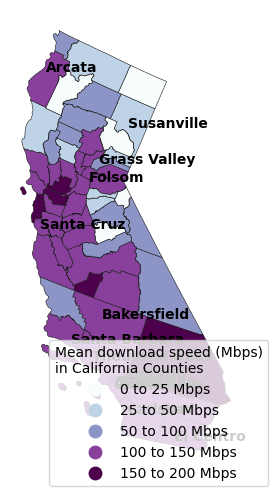

In [41]:
fig, ax = plt.subplots(1, figsize=(16, 6))

county_data.plot(
    column="group", cmap="BuPu", linewidth=0.4, ax=ax, edgecolor="0.1", legend=True
)

ax.axis("off")

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 0.3))
leg.set_title("Mean download speed (Mbps)\nin California Counties")

texts = []
for x, y, label in zip(ky_places.geometry.x, ky_places.geometry.y, ky_places["NAME"]):
    texts.append(plt.text(x, y, label, fontsize=10, fontweight="bold", ha="left"))

adjust_text(
    texts,
    force_points=0.3,
    force_text=0.8,
    expand_points=(1, 1),
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
)